In [74]:
!pip install -q torch-audiomentations
!pip install -q torchaudio
!pip install -q julius

In [68]:
import platform
os_name = platform.system()

import numpy as np
from glob import glob
from IPython.display import Audio
import torch
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [2]:
speak_files=glob("cv-corpus-9.0-2022-04-27/zh-TW/clips/*.mp3")
firetruck_files=glob("sounds/firetruck/*.wav")
construction_files=glob("sounds/splited_construction/*.wav")
print(
    "#人聲:",len(speak_files),
    "\n#消防車聲:",len(firetruck_files),
    "\n#工地聲:",len(construction_files)
)

#人聲: 116969 
#消防車聲: 200 
#工地聲: 11997


In [3]:
SEED=28
SAMPLE_RATE=16000
kwargs=dict(
    sr=SAMPLE_RATE,
    mono=True
)
# x_signal,_=librosa.load(speak_files[SEED],**kwargs)
# x_artifact,_=librosa.load(firetruck_files[SEED],**kwargs)
# x_noise,_=librosa.load(construction_files[4],**kwargs)

In [607]:
from torch_audiomentations import Compose, Gain,PitchShift,Shift,AddBackgroundNoise

import torch.utils.data as tud
import torchaudio
from julius.resample import ResampleFrac

if os_name=="Linux":
    torchaudio.set_audio_backend("sox_io") # for Linux system
common_kwargs={"sample_rate":SAMPLE_RATE,
            "mode":"per_example"}
common_proc=[
    PitchShift(# Pitch shift (frequency) without changinng meaning
                    min_transpose_semitones= -4.0, 
                    max_transpose_semitones= +1.0,
                    p=0.8,
                    **common_kwargs),
    Shift( # Waveform time shift (ratio) without changing shape
        min_shift=-0.5,
        max_shift=0.5,
        p=0.8,
        **common_kwargs),
]
class SyntheticCallDataset(tud.IterableDataset):
    def __init__(self,
                 signal_files,
                 artifact_dir,
                 noise_dir,
                 signal_len,
                 transform=None):
        super().__init__()
        self.device=torch.device("cuda")
        self.signal_files=signal_files
        self.artifact_dir=artifact_dir
        self.noise_dir=noise_dir
        self.signal_len=signal_len
        # Initialize augmentation callable
        self.transform=transform
        self.artifact_transform = Compose(
            transforms=[
                AddBackgroundNoise(
                    background_paths=artifact_dir,
                    min_snr_in_db=-12.,
                    max_snr_in_db=-1.,
                    p=1.0,
                    **common_kwargs),
                *common_proc
            ]
        )
        self.noise_transform = Compose(
            transforms=[
                AddBackgroundNoise(
                    background_paths=noise_dir,
                    min_snr_in_db=-12.,
                    max_snr_in_db=-1.,
                    p=1.0,
                    **common_kwargs),
               *common_proc
            ]
        )
        # Resamplers for Frequency alignment
        self.resamp_32Kto16K=ResampleFrac(32000,16000).to(self.device)
        self.resamp_48kto16K=ResampleFrac(48000,16000).to(self.device)
        # Resamplers for synthetic signal generation
        self.resamp_16Kto8K=ResampleFrac(16000,8000).to(self.device)
    def __len__(self):
        return len(self.signal_files)
    def __iter__(self):
        idxs=np.random.permutation(len(self))
        for idx in idxs[:360]:
            ##### Load signal #####
            signal_,sr_orig=torchaudio.load(self.signal_files[idx],normalize=False)
            # Resample
            if sr_orig==48000:
                signal_=self.resamp_48kto16K(signal_.to(self.device))
            elif sr_orig==32000:
                signal_=self.resamp_32Kto16K(signal_.to(self.device))
            else:
#                 is_valid_sr=(sr_orig in [48000,32000], "Unsupported Sample Rate")
                assert sr_orig in [48000,32000], "Unsupported Sample Rate"
            if self.transform:
                signal_=self.transform(signal_[None,...])[0]
            ## Padding if needed
            if len(signal_[0])<self.signal_len:
                signal=torch.zeros((1,self.signal_len),dtype=torch.float32,device=self.device)
                start_point=np.random.randint(0,self.signal_len-len(signal_[0]))
                end_point=start_point+len(signal_[0])
                signal[:,start_point:end_point]=signal_
            else:
                signal=signal_[:,:self.signal_len]
                
            ##### Load noise #####
            artifact=torch.randn((1,self.signal_len),dtype=torch.float32,device=self.device)*0.1
            noise=torch.randn((1,self.signal_len),dtype=torch.float32,device=self.device)*0.1
            
            if self.artifact_transform:
                artifact=self.transform(artifact[None,...])[0]
            if self.noise_transform:
                noise=self.transform(noise[None,...])[0]
            
            yield signal,artifact,noise
    def collate_fn(self,batch):
        signal,artifact,noise=[torch.stack([b[i] for b in batch],dim=0) for i in range(3)]
        # Augmentation    
            
        # Synthesize
        x=self.resamp_16Kto8K(signal+artifact+noise)
        return x,signal,artifact,noise

In [608]:
from torch_audiomentations import Compose, Gain,PitchShift,Shift,AddBackgroundNoise
common_={"sample_rate":SAMPLE_RATE,
            "mode":"per_example",
            "p":0.5}
transform = Compose(
    transforms=[
        PitchShift(# Pitch shift (frequency) without changinng meaning
            min_transpose_semitones= -4.0, 
            max_transpose_semitones= +4.0, 
            **common_),
        Shift( # Waveform time shift (ratio) without changing shape
            min_shift=-0.8,
            max_shift=0.8,
            **common_),
        Gain( # louder or quieter
            min_gain_in_db=-5.0,
            max_gain_in_db=5.0,
            **common_),
    ]
)

In [609]:
train_ds=SyntheticCallDataset(speak_files,
                              artifact_dir='sounds/firetruck/',
                              noise_dir='sounds/splited_construction/',
                              signal_len=16000*2,
                              transform=transform)

In [610]:
train_dl=tud.DataLoader(train_ds,batch_size=8,collate_fn=train_ds.collate_fn)

In [611]:
%%time
for  x,signal,artifact,noise in train_dl:
    break

CPU times: user 130 ms, sys: 12.1 ms, total: 142 ms
Wall time: 289 ms


In [537]:
Audio(x[3].cpu() ,rate=8000)

In [538]:
Audio(signal[1].cpu() ,rate=16000)

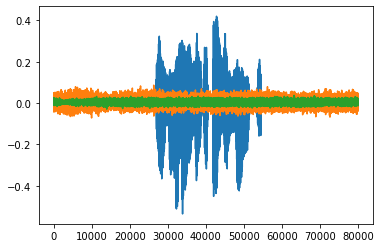

In [542]:
plt.plot(signal[0].cpu().numpy().T)
plt.plot(artifact[0].cpu().numpy().T)
plt.plot(noise[0].cpu().numpy().T)

In [15]:
# Setup common parameters for augmentation functions



In [12]:
import torchaudio

In [5]:
torchaudio.__version__

'0.9.0'

In [ ]:
https://pytorch.org/audio/0.11.0/models.html

In [16]:
samples1, _ = librosa.load(noise[0][0],
                           sr=SAMPLE_RATE,
                           mono=False)
samples1=torch.from_numpy(samples1[None,...])

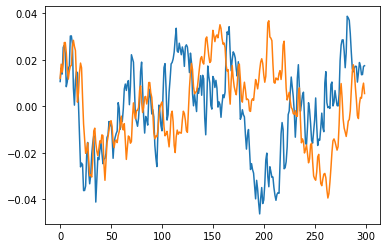

In [17]:
plt.plot(samples1[0,0,:300].T)
plt.plot(transform_siren(samples1)[0,0,:300].T)
plt.show()

In [47]:
torchaudio.load('cv-corpus-9.0-2022-04-27/zh-TW/clips/common_voice_zh-TW_30673318.mp3')

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0015, -0.0013, -0.0009]]), 32000)

In [42]:
Audio(data,rate=sr)

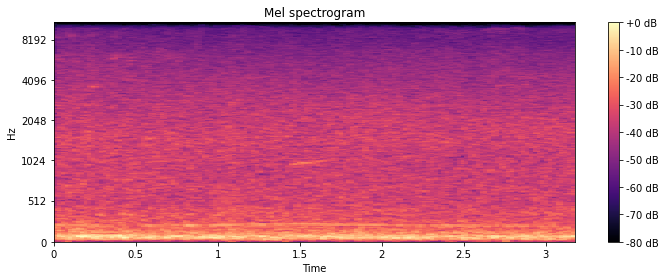

In [31]:
see_spectrum(samples1[0,0].numpy())

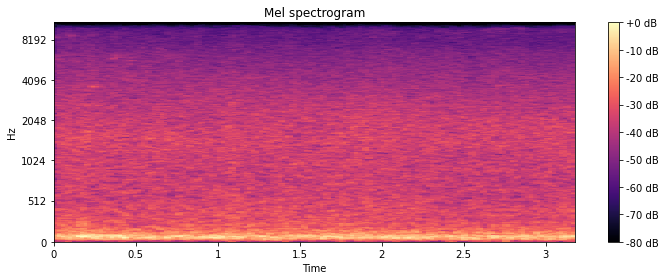

In [32]:
see_spectrum(samples1[0,1].numpy())

In [34]:
Audio(samples1[0,1],rate=SAMPLE_RATE)